# Exercise: Insights

- A Studio that produces movies asked us whether we could provide valuable (for them) insights based on our data.

- Also, our procurement team, ie the team that signs new studios and new films, asked us whether we could help them make data-driven decisions on what films to sign next.

In [2]:
import re
from datetime import datetime
import numpy as np
import pandas as pd
import dask.dataframe as dd

# visualization imports
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from wordcloud import WordCloud

%matplotlib inline

In [3]:
movies_df = pd.read_csv("/Users/cesareressa/Documents/datasets/movies.csv")
ratings_df = pd.read_csv("/Users/cesareressa/Documents/datasets/ratings.csv")
tags_df = pd.read_csv("/Users/cesareressa/Documents/datasets/tags.csv")

Exploratory Analysis

In [33]:
#add dummy inisghts from expl analysis
#how many movies are rated?
len(ratings_df.movieId.unique())

#how many movies are tagged?
#number of movies with tags

len(tags_df.movieId.unique())

#how many users

#what is the oldest movie

#what is the latest movie

#how many movies don't have a production year?

# movies_df[movies_df.movie_year.isna()]

45981

Transform datasets 

In [4]:
# add movie year column and convert it
movies_df["movie_year"] = movies_df.title.str.extract(r"\((\d{4})\)(?!.*\(\d{4}\))")
movies_df["movie_year"] = pd.to_numeric(movies_df.movie_year, downcast="integer", errors="coerce")

#split genres
movies_df["genres"] = movies_df["genres"].str.split("|")



In [5]:
# create dask dataframes
dd_movies = dd.read_csv("/Users/cesareressa/Documents/datasets/movies.csv")
dd_ratings = dd.read_csv("/Users/cesareressa/Documents/datasets/ratings.csv")
dd_tags = dd.read_csv("/Users/cesareressa/Documents/datasets/tags.csv")

# merge with dask and move to pandas df
dd_user_info = dd.merge(dd_ratings, dd_tags, how="left", on=["userId", "movieId"], suffixes=("_rating", "_tag"))
df_user_info = dd_user_info.compute()

dd_complete = dd.merge(df_user_info, dd_movies, how="left", on="movieId")
df_complete = dd_complete.compute()

In [6]:
#can we use dask for this?

df_complete["datetime_rating"] = pd.to_datetime(df_complete["timestamp_rating"], unit="s")
df_complete["datetime_tag"] = pd.to_datetime(df_complete["timestamp_tag"], unit="s")
df_complete["genres"] = df_complete["genres"].str.split("|")
df_complete["movie_year"] = df_complete.title.str.extract(r"\((\d{4})\)(?!.*\(\d{4}\))")
df_complete["movie_year"] = pd.to_numeric(df_complete.movie_year, downcast="integer", errors="coerce")

In [7]:
df_complete

,userId,movieId,rating,timestamp_rating,tag,timestamp_tag,title,genres,datetime_rating,datetime_tag,movie_year
0,1,307,3.5,1256677221,NaN,NaN,Three Colors: Blue (Trois couleurs: Bleu) (1993),[Drama],2009-10-27 21:00:21,NaT,1993.0
1,106361,8368,3.5,1501871808,NaN,NaN,Harry Potter and the Prisoner of Azkaban (2004),"[Adventure, Fantasy, IMAX]",2017-08-04 18:36:48,NaT,2004.0
2,131346,4816,1.5,1433273308,NaN,NaN,Zoolander (2001),[Comedy],2015-06-02 19:28:28,NaT,2001.0
3,206877,208,4.0,854979504,NaN,NaN,Waterworld (1995),"[Action, Adventure, Sci-Fi]",1997-02-03 14:18:24,NaT,1995.0
4,53456,1777,3.0,945051094,NaN,NaN,"Wedding Singer, The (1998)","[Comedy, Romance]",1999-12-13 02:11:34,NaT,1998.0
...,...,...,...,...,...,...,...,...,...,...,...
28363491,27045,260,5.0,955118461,NaN,NaN,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Sci-Fi]",2000-04-07 14:41:01,NaT,1977.0
28363492,27045,317,5.0,955121387,NaN,NaN,"Santa Clause, The (1994)","[Comedy, Drama, Fantasy]",2000-04-07 15:29:47,NaT,1994.0
28363493,27045,349,4.0,955119023,NaN,NaN,Clear and Present Danger (1994),"[Action, Crime, Drama, Thriller]",2000-04-07 14:50:23,NaT,1994.0
28363494,27045,367,4.0,955121417,NaN,NaN,"Mask, The (1994)","[Action, Comedy, Crime, Fantasy]",2000-04-07 15:30:17,NaT,1994.0


In [8]:
#move to filters.py

def filter_time_interval(df: pd.DataFrame, start_date: datetime, end_date: datetime) -> pd.DataFrame:
    """
    Use to filter the dataset based on time interval. The time interval has been inferred from the time a movie has been rated, assuming that the userId rated the movie right after watching it. 
    Args: df: pandas df with datetime_rating (assumed to be approximately the moment the movie has been watched), start_date, end_date.
    Returns: pandas df filtered for a defined time interval.
    """
    return df.loc[(df.datetime_rating >= start_date) & (df.datetime_rating <= end_date)].sort_values(by= "datetime_rating", ascending= False)

def filter_production_date(df: pd.DataFrame, prod_start: int, prod_end: int) -> pd.DataFrame:
    """
    Use to filter the dataset based on production movie years.
    Args: df: pandas df with movie titles and production movie year, prod_start: start prodcution movie year, prod_end: end production movie year.
    Returns: pandas df filter by production movie year interval.
    """
    return df.loc[(df.movie_year >= prod_start) & (df.movie_year <= prod_end)]

In [9]:
# move to data_getters.py

def get_tags_per_movieId(movieId:int) -> list:
    return list(tags_df[tags_df.movieId == movieId]["tag"])

def aggregate_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Use to aggregate total_views (count_views), average_ratings (rating_means), and get all tags collected per movieId
    Arg: dataframe with preferred time interval already defined
    Returns: a copy datframe of movies_df
    """

    movies_df_copy = movies_df.copy()

    count_views = pd.DataFrame(df.groupby("movieId")["movieId"].count()).rename(columns={"movieId": "total_views"})

    rating_means = pd.DataFrame(df.groupby("movieId")["rating"].mean()).rename(columns={"rating": "average_rating"})

    movies_df_copy = pd.merge(movies_df, count_views, on="movieId")

    movies_df_copy = pd.merge(movies_df_copy,  rating_means, on="movieId")

    #get all tags per movieId
    movies_df_copy["tags"] = movies_df_copy["movieId"].apply(lambda x: get_tags_per_movieId(x))

    return movies_df_copy

In [10]:
def generate_plots(movies_df: pd.DataFrame, decade: int, top: int = 20):
    """
    Use to generate insights based on movies_df. By default, the insights will be generated based on the top 20 movies. 
    """

    # Sample data
    movies_df = movies_df.sort_values(by="total_views", ascending=False).head(top)

    # Define colors for shading based on ratings
    cmap = plt.cm.get_cmap('viridis', 10)  # Choose a colormap with 10 shades
    ratings = movies_df["average_rating"]  # Ratings data from your dataframe
    normalized_ratings = (ratings - 1) / 4  # Normalize ratings to range [0,1]
    colors = cmap.reversed()(normalized_ratings)  # Reverse the colormap

    # Create a figure with three subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    # Reduce alpha value to increase contrast of bars
    colors = [(c[0], c[1], c[2], 0.7) for c in colors]  # Set alpha value to 0.7

    # Plot the horizontal bar chart on the first subplot
    barh = axs[0].barh(movies_df["title"], movies_df["total_views"], color=colors)
    axs[0].set_xlabel('Total views')
    axs[0].set_title(f'Total Views by Top {top} movies produced in the {decade}s and Average Ratings', fontweight="bold")

    # Create a custom legend for the first subplot
    legend_labels = [plt.Line2D([0], [0], color=cmap.reversed()(0.2), lw=6),
                     plt.Line2D([0], [0], color=cmap.reversed()(0.5), lw=6),
                     plt.Line2D([0], [0], color=cmap.reversed()(0.8), lw=6)]
    legend_texts = ['Low Rating (<3)', 'Medium Rating (3)', 'High Rating (>3)']
    axs[0].legend(legend_labels, legend_texts, loc='upper right')

    # Add rating labels inside the bars in the first subplot
    for i, bar in enumerate(barh):
        rating = movies_df.iloc[i]["average_rating"]
        axs[0].text(bar.get_width() - 0.2, bar.get_y() + bar.get_height() / 2, f"{rating:.1f}",
                    color='white', ha='right', va='center')

    # Plot the scatter plot on the second subplot
    axs[1].scatter(movies_df.sort_values(by="total_views", ascending=False)["average_rating"],
                   movies_df.sort_values(by="total_views", ascending=False)["total_views"], color="green")
    axs[1].set_xlabel("Average Rating")
    axs[1].set_ylabel("Total Views")
    axs[1].set_title(f"Correlation between Total Views and Average Rating of the Top {top} movies produced in the {decade}s", fontweight="bold")

    # Generate the word cloud from the "tags" column on the third subplot
    wordcloud = WordCloud(width=800, height=400).generate(' '.join(movies_df['tags'].explode().dropna()))

    # Plot the word cloud on the third subplot
    axs[2].imshow(wordcloud, interpolation='bilinear')
    axs[2].axis('off')
    axs[2].set_title(f'Tags generated by the users for these movies', fontweight="bold")

    # Adjust layout to prevent overlapping labels
    plt.tight_layout()

    # Show the plot
    plt.show


In [11]:
# find closest match

# Scenario: The procurement team had been proposed a certain movie (e.g. a movie produced in 2013). We don't have any data about it yet but we can try to "test" it against our dataset
# and see how a similar movie behaved 

# input: genre, production date

def find_closest_match(genre, prod_year, dataset):
    """
    Use it to compare a proposed new movie against similar movies in the dataset and visualize how the similar movies behaved.
    Args: genre (str) choose a genre among the available genres, prod_year (int) is the production year of the proposed new movie.
    Returns: decade (int), filtered dataframe per genre and decade.
    """
    #Define decade in which the proposed movie has been produced
    decade = prod_year //10*10
    #filter df per start and end decade (+9 yrs)
    filter_df = filter_production_date(dataset, decade, decade+9)
    filter_df = filter_df.explode("genres")

    # filter df per genre
    return decade, filter_df[filter_df["genres"].str.contains(genre)]

#for more granular data, pass the generated df to filter_time_interval()

Our procurement team, ie the team that signs new studios and new films, asked us whether we could help them make data-driven decisions on what films to sign next.

In [14]:
# find closest match

# Scenario: The procurement team had been proposed a certain movie (e.g. a movie produced in 2013). We don't have any data about it yet but we can try to "test" it against our dataset
# and see how a similar movie behaved 


dataset = df_complete.copy()

def find_closest_match(genre, prod_year):
    """
    Compare a proposed new movie against similar movies in the dataset and visualize how the similar movies behaved.
    
    Args:
        genre (str): Genre of the proposed new movie.
        prod_year (int): Production year of the proposed new movie.
        dataset (pd.DataFrame): Dataset of movies to compare against.
        
    Returns:
        filter_df (pd.DataFrame): Filtered dataframe per genre and decade.
        aggregate_df (pd.DataFrame): Aggregated data for visualization.
    """
    #Define decade in which the proposed movie has been produced
    decade = prod_year //10*10
    #filter df per start and end decade (+9 yrs)
    filter_df = filter_production_date(dataset, decade, decade+9)
    filter_df = filter_df.explode("genres")
    filter_df = filter_df[filter_df["genres"].str.contains(genre)]

    aggregate_df = aggregate_data(filter_df)

    generate_plots(aggregate_df, decade)

    return filter_df, aggregate_df

#for more granular data, pass the generated df to filter_time_interval()

/var/folders/7h/4bpx64_97yb6d8pfkbnq3vjw0000gn/T/ipykernel_44711/3474983526.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 10)  # Choose a colormap with 10 shades


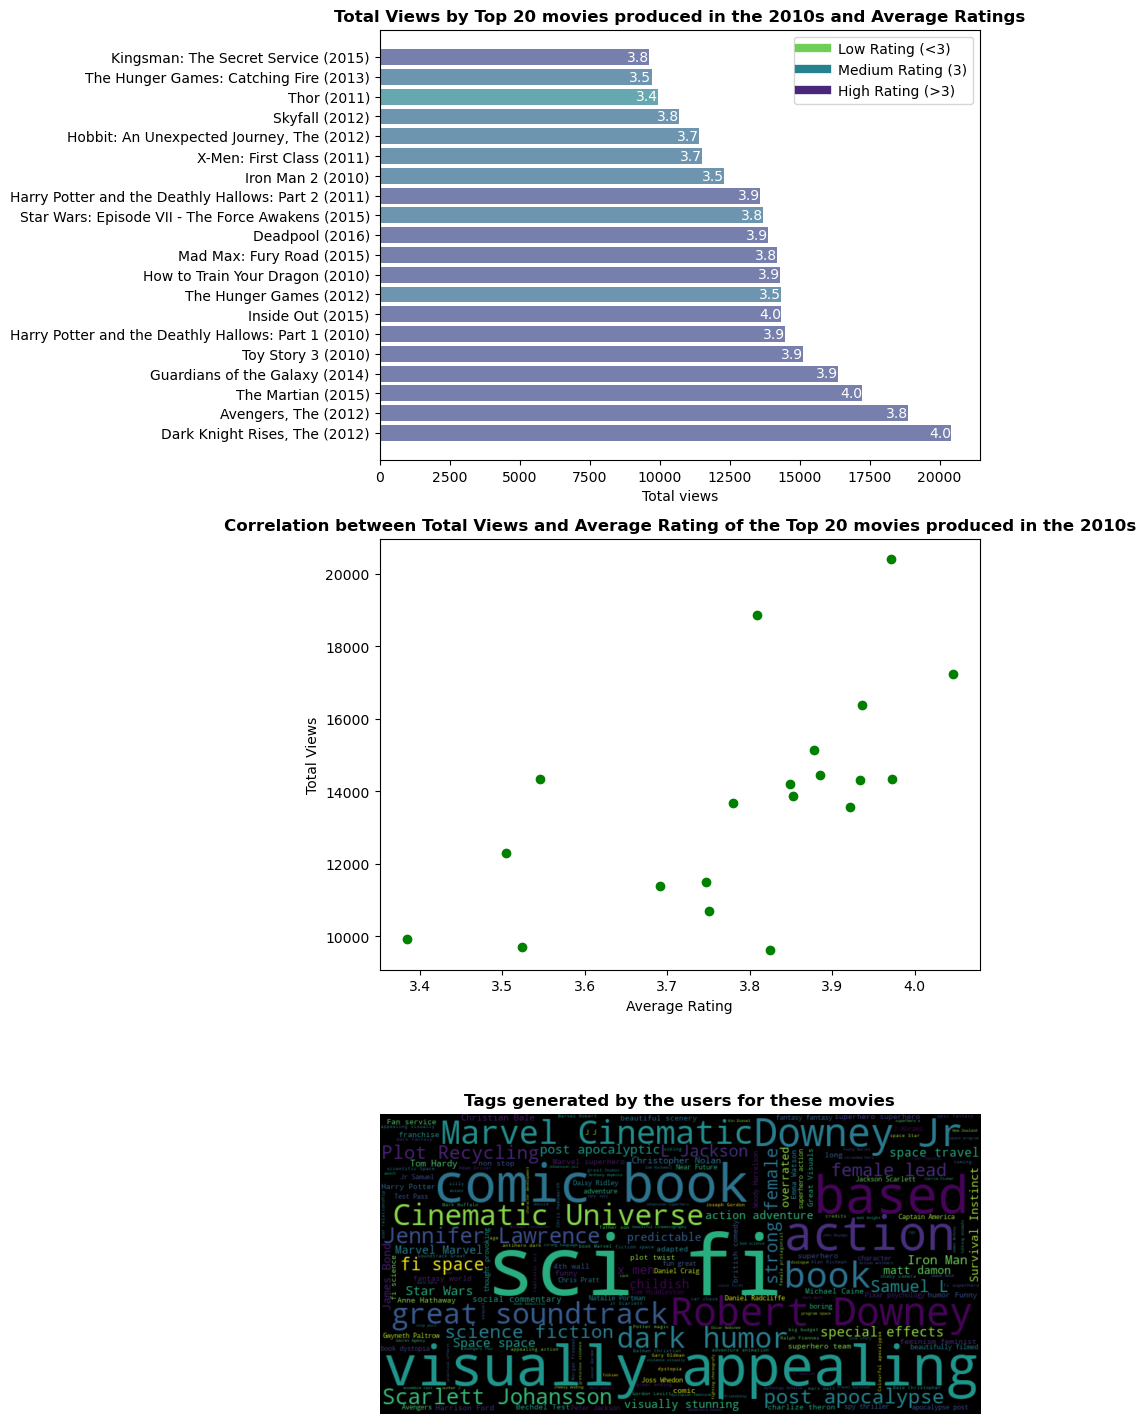

In [15]:
queried_movies, aggregate_df = find_closest_match("Adventure", 2017)

General insights - Useful for the studio that produces movies.

In [122]:
#what is the most popular movie of all time

count_movies = dataset.movieId.value_counts()

count_movies.head(10)

movieId
318     100805
356      99162
296      96271
593      89651
2571     87652
260      85743
480      77114
527      72618
110      69450
1        68972
Name: count, dtype: int64

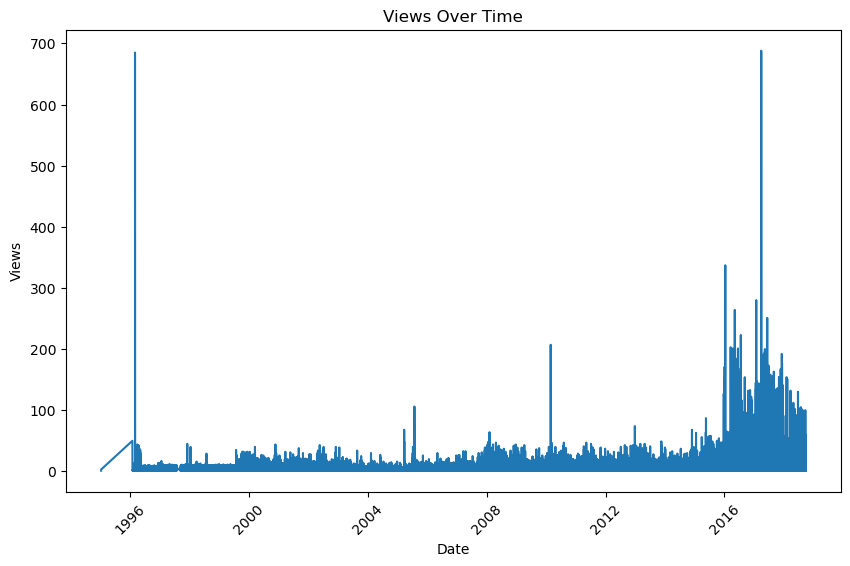

In [123]:
# plot views over time

# Group by datetime_rating and count the number of occurrences to get the views over time
views_over_time = dataset.copy().groupby("datetime_rating").size().reset_index(name="views")

# Convert the "datetime_rating" column to datetime type
# views_over_time["datetime_rating"] = pd.to_datetime(views_over_time["datetime_rating"])

# Set the "datetime_rating" column as the index
views_over_time.set_index("datetime_rating", inplace=True)

# Create a line plot of views over time
plt.figure(figsize=(10, 6))
plt.plot(views_over_time.index, views_over_time["views"])
plt.xlabel("Date")
plt.ylabel("Views")
plt.title("Views Over Time")
plt.xticks(rotation=45)
plt.show()

In [43]:
views_over_time_by_genre = df_complete.copy().explode("genres")

views_over_time_by_genre = filter_time_interval(views_over_time_by_genre, datetime(2017,1,1), datetime(2017,1,2))

views_over_time_by_genre = views_over_time_by_genre.groupby(["datetime_rating", "genres"]).size()

# Convert the "datetime_rating" column to datetime type
# views_over_time_by_genre["datetime_rating"] = pd.to_datetime(views_over_time_by_genre["datetime_rating"])

# # Pivot the data to have genres as columns
# views_over_time_by_genre_pivot = views_over_time_by_genre.pivot(index="datetime_rating", columns="genres", values="views")

# # # Create a line plot of views over time with different lines for each genre
# plt.figure(figsize=(10, 6))
# for genre in views_over_time_by_genre_pivot.columns:
#     plt.plot(views_over_time_by_genre_pivot.index, views_over_time_by_genre_pivot[genre], label=genre)
# plt.xlabel("Date")
# plt.ylabel("Views")
# plt.title("Views Over Time by Genre")
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()

In [44]:
views_over_time_by_genre

datetime_rating      genres  
2017-01-01 00:00:00  Drama       1
2017-01-01 00:00:14  Comedy      1
                     Drama       1
                     Romance     1
2017-01-01 00:00:16  Drama       1
                                ..
2017-01-01 23:59:59  Action      1
                     Horror      1
                     IMAX        1
                     Sci-Fi      1
                     Thriller    1
Length: 15160, dtype: int64

In [46]:
views_over_time_by_genre = pd.DataFrame(views_over_time_by_genre).reset_index().rename(columns={0: "views"})

views_over_time_by_genre_pivoted = views_over_time_by_genre.pivot(index="datetime_rating", columns="genres", values="views")

# views_over_time_by_genre_pivot = views_over_time_by_genre.pivot(index="datetime_rating", columns="genres", values="views")

# Create a line plot of views over time with different lines for each genre
# plt.figure(figsize=(10, 6))
# for genre in views_over_time_by_genre_pivoted.columns:
#     plt.plot(views_over_time_by_genre_pivoted.index, views_over_time_by_genre_pivoted[genre], label=genre)
# plt.xlabel("Date")
# plt.ylabel("Views")
# plt.title("Views Over Time by Genre")
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()

In [47]:
views_over_time_by_genre_pivoted

genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
datetime_rating,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:00:14,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2017-01-01 00:00:16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2017-01-01 00:00:30,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:00:34,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01 23:59:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2017-01-01 23:59:47,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN
2017-01-01 23:59:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


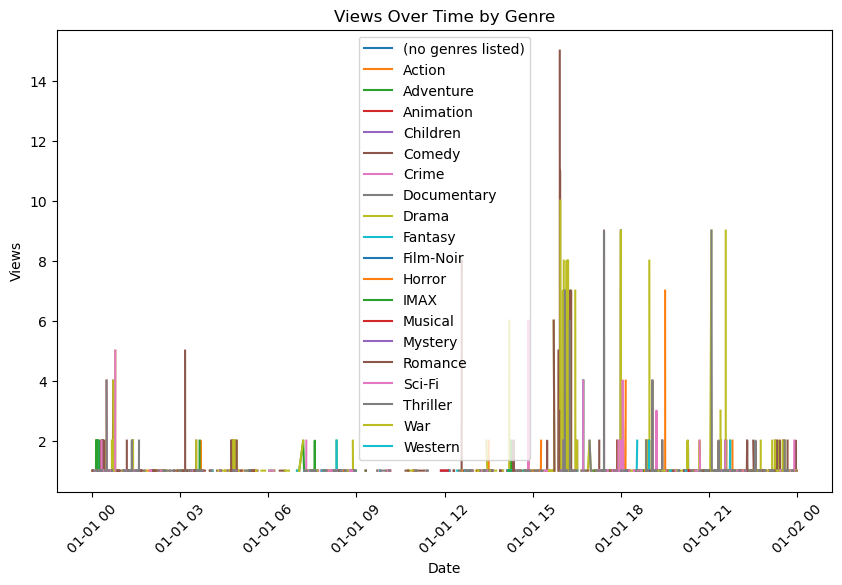

In [54]:
genres_list = views_over_time_by_genre_pivoted.columns

# Create a line plot of views over time with different lines for each genre
plt.figure(figsize=(10, 6))
for genre in views_over_time_by_genre_pivoted.columns:
    plt.plot(views_over_time_by_genre_pivoted.index, views_over_time_by_genre_pivoted[genre], label=genre)
plt.xlabel("Date")
plt.ylabel("Views")
plt.title("Views Over Time by Genre")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [58]:
list(views_over_time_by_genre_pivoted.columns)

['(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the "genres" column to a string representation
dataset = filter_time_interval(dataset, datetime(2017-1-1), datetime(2017-12-31))

# dataset["genres"] = dataset["genres"].apply(lambda x: ' '.join(x))

# # Group by datetime_rating and genres, and count the number of occurrences to get the views over time for each genre
# views_over_time_by_genre = dataset.groupby(["datetime_rating", "genres"]).size().reset_index(name="views")

# # Convert the "datetime_rating" column to datetime type
# views_over_time_by_genre["datetime_rating"] = pd.to_datetime(views_over_time_by_genre["datetime_rating"])

# # Pivot the data to have genres as columns
# views_over_time_by_genre_pivot = views_over_time_by_genre.pivot(index="datetime_rating", columns="genres", values="views")

# # Create a line plot of views over time with different lines for each genre
# plt.figure(figsize=(10, 6))
# for genre in views_over_time_by_genre_pivot.columns:
#     plt.plot(views_over_time_by_genre_pivot.index, views_over_time_by_genre_pivot[genre], label=genre)
# plt.xlabel("Date")
# plt.ylabel("Views")
# plt.title("Views Over Time by Genre")
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()


NameError: name 'filter_time_interval' is not defined

In [128]:
views_over_time_by_genre.index

MultiIndex([('1995-01-09 11:46:44',     'Drama'),
            ('1995-01-09 11:46:44',   'Fantasy'),
            ('1995-01-09 11:46:44',   'Romance'),
            ('1995-01-09 11:46:49',    'Comedy'),
            ('1995-01-09 11:46:49',     'Crime'),
            ('1995-01-09 11:46:49',   'Mystery'),
            ('1995-01-09 11:46:49',  'Thriller'),
            ('1996-01-29 00:00:00',    'Action'),
            ('1996-01-29 00:00:00', 'Adventure'),
            ('1996-01-29 00:00:00', 'Animation'),
            ...
            ('2018-09-26 06:58:47',    'Action'),
            ('2018-09-26 06:58:47', 'Adventure'),
            ('2018-09-26 06:58:47',  'Thriller'),
            ('2018-09-26 06:58:50',    'Action'),
            ('2018-09-26 06:58:50', 'Adventure'),
            ('2018-09-26 06:58:50',     'Crime'),
            ('2018-09-26 06:58:50',    'Horror'),
            ('2018-09-26 06:58:50',  'Thriller'),
            ('2018-09-26 06:59:09',    'Action'),
            ('2018-09-26 06:59:09'

In [ ]:
# count_movies = pd.DataFrame({"total_views": count_movies})

count_movies = pd.DataFrame(count_movies)

count_movies = count_movies.rename(columns={"movieId": "total_views"})

count_movies

rating_means = pd.DataFrame(ratings_df.groupby("movieId")["rating"].mean())

rating_means


In [ ]:
movies_df = pd.merge(movies_df, count_movies, left_on="movieId", right_on=count_movies.index)

movies_df = pd.merge(movies_df,  rating_means, on="movieId")

In [ ]:
# movies_df["genres_list"] = movies_df["movieId"].map(lambda x : genres_per_movie_dict[x])

# movies_df["genres"] = movies_df["genres"].str.split("|")


In [ ]:
movies_df

Most watched movies of all times

In [74]:
aggregate_df = aggregate_data(dataset)

most_watched_movies_df = aggregate_df.sort_values(by="total_views", ascending=False)

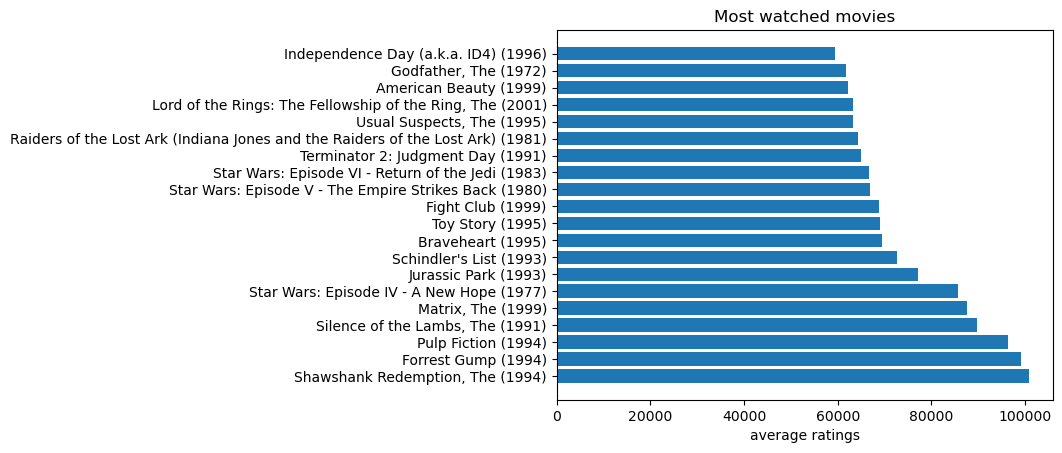

In [78]:
plt.barh(most_watched_movies_df.title.head(20), most_watched_movies_df.total_views.head(20))

plt.title("Most watched movies")
plt.xlabel("average ratings")
plt.show()

Which genre is the most watched?

In [103]:
top_genres = most_watched_movies_df.copy()

top_genres = top_genres.explode("genres")

top_genres = pd.DataFrame(top_genres.groupby("genres")["movieId"].count()).rename(columns={"movieId": "views"}).sort_values(by="views", ascending=False)

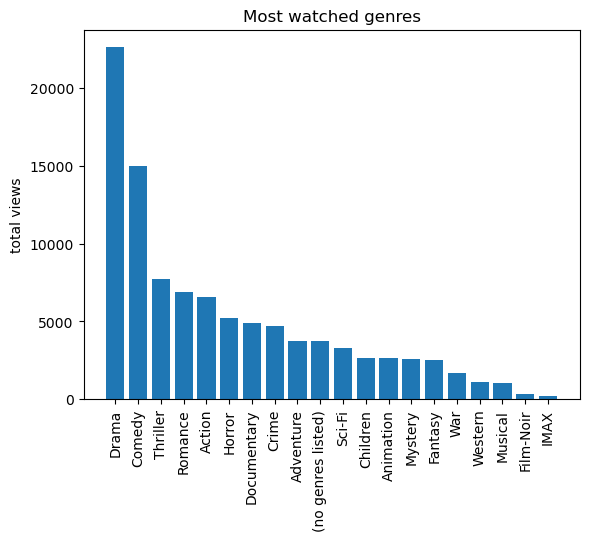

In [114]:
plt.bar(top_genres.index, top_genres.views)
plt.xticks(rotation = 90)
plt.title("Most watched genres")
plt.ylabel("total views")
plt.show()

In [87]:
# Query the highest rated movies by genre 

#Input different type of genre
genre = "Comedy"

highest_rated_movies_by_genre_df = aggregate_df.explode("genres")

highest_rated_movies_by_genre_df = highest_rated_movies_by_genre_df[highest_rated_movies_by_genre_df.genres == genre].sort_values(by="average_rating", ascending=False)

In [88]:
highest_rated_movies_by_genre_df

,movieId,title,genres,movie_year,total_views,average_rating,tags
44857,171807,Caedes (2015),Comedy,2015.0,1,5.0,[splatter]
48285,179759,The Lost Letter (1972),Comedy,1972.0,2,5.0,"[Soviet, Ukrainian]"
52044,188821,Messengers (1999),Comedy,1999.0,10,5.0,"[90s, hidden gem, hilarious, Hiroyuki Yabe, Ja..."
47144,176959,The Chess Game (1994),Comedy,1994.0,1,5.0,[]
30986,135232,Jailbait Babysitter (1977),Comedy,1977.0,1,5.0,[babysitter]
...,...,...,...,...,...,...,...
40106,159968,L'année prochaine... si tout va bien (1981),Comedy,1981.0,1,0.5,"[cartoonist, love, youth]"
40157,160104,Ribbit (2014),Comedy,2014.0,1,0.5,"[3d, adventure, animal, animation]"
40256,160346,"Class of Nuke 'Em High 3: The Good, the Bad an...",Comedy,1994.0,7,0.5,"[bad sequel, borderline unwatchable, low budge..."
31682,136922,Bordering on Bad Behavior (2015),Comedy,2015.0,1,0.5,[]


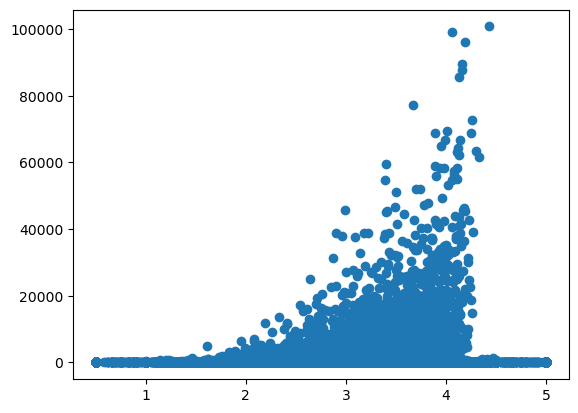

In [71]:
# ratings vs total views

plt.scatter(aggregate_df["average_rating"], aggregate_df["total_views"])

In [ ]:
display(movies_df.loc[(movies_df["total_views"] > 50000) & (movies_df["rating"] > 3.8)])